Let's first install some tools.

In [1]:
%pip install scikit-learn scikit-lego

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Voting Classifier

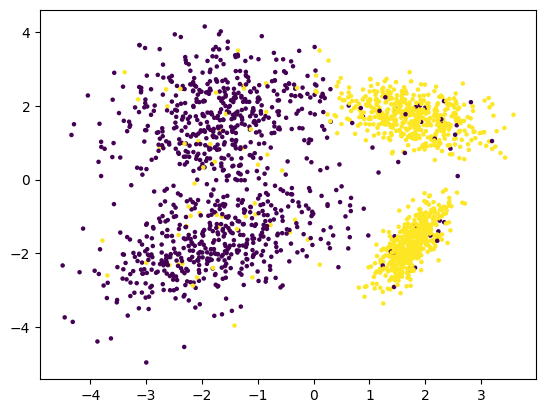

In [2]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000, n_features=2,
                           n_redundant=0, random_state=21,
                           class_sep=1.75, flip_y=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [3]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

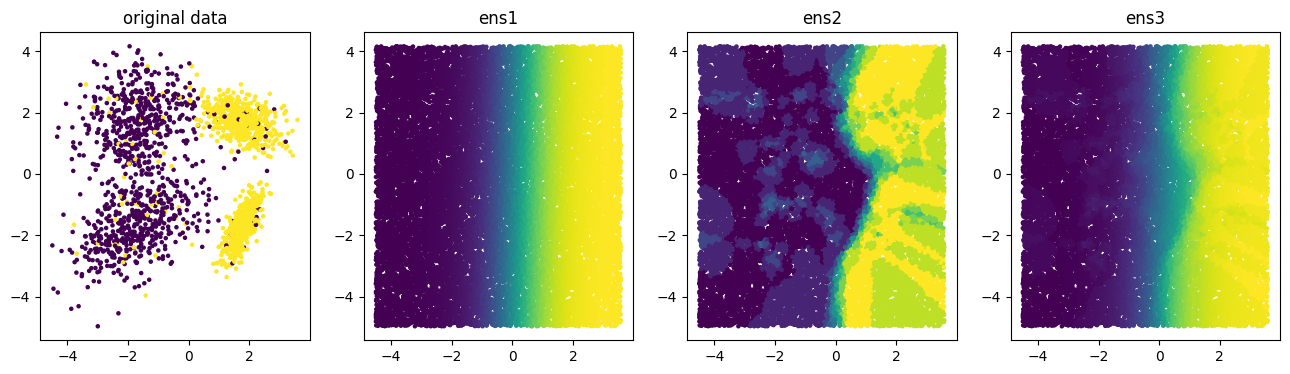

In [4]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft',
                        weights=[10.5, 2.5])
clf3.fit(X, y)

make_plots()

## Threshold

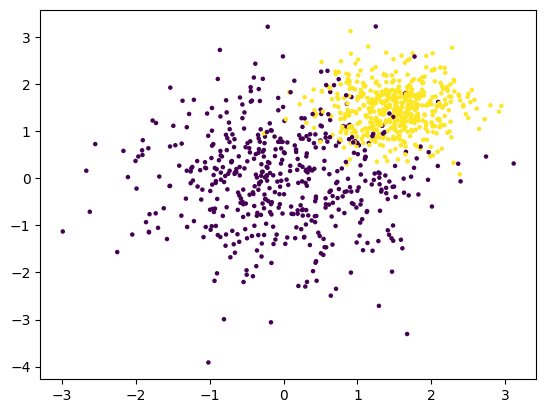

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

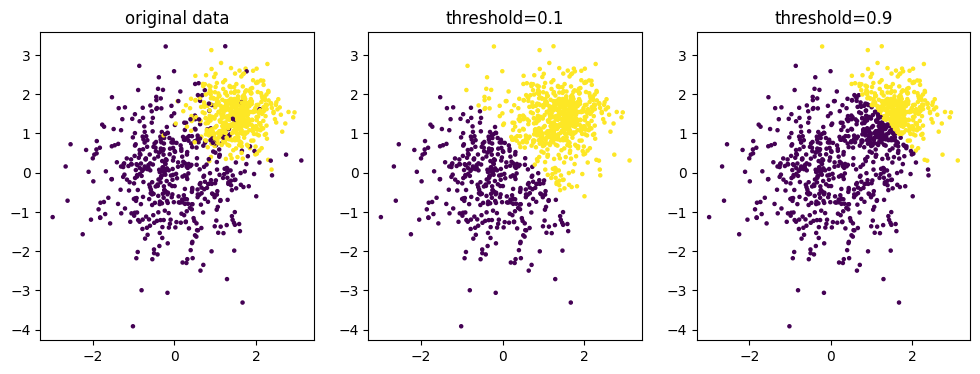

In [6]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [7]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y);


## Grouped Models

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda df: model.predict(df[['diet', 'time']]))
    print(metric_df.sample(6))
    print(metric_df.shape)
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    # plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda df: df['diet'] == i]
        print(pltr.head(13))
        print(pltr.shape)
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

In [9]:
x=3
tx = lambda n: x*2
tx(2)


6

     diet  time  weight    pred
6       1    12     106  115.00
487     4     6      96   94.25
567     4     2      54   59.25
418     3    12     103  153.50
114     1    14      96  132.50
65      1    10     124   97.50
(578, 4)
    time  diet    pred
0      0     1    9.75
1      2     1   27.25
2      4     1   44.75
3      6     1   62.25
4      8     1   80.00
5     10     1   97.50
6     12     1  115.00
7     14     1  132.50
8     16     1  150.00
9     18     1  167.50
10    20     1  185.25
11    21     1  194.00
(12, 3)
     time  diet    pred
220     0     2   27.00
221     2     2   44.50
222     4     2   62.00
223     6     2   79.50
224     8     2   97.25
225    10     2  114.75
226    12     2  132.25
227    14     2  149.75
228    16     2  167.25
229    18     2  184.75
230    20     2  202.50
231    21     2  211.25
(12, 3)
     time  diet    pred
340     0     3   48.25
341     2     3   65.75
342     4     3   83.25
343     6     3  100.75
344     8     3  118

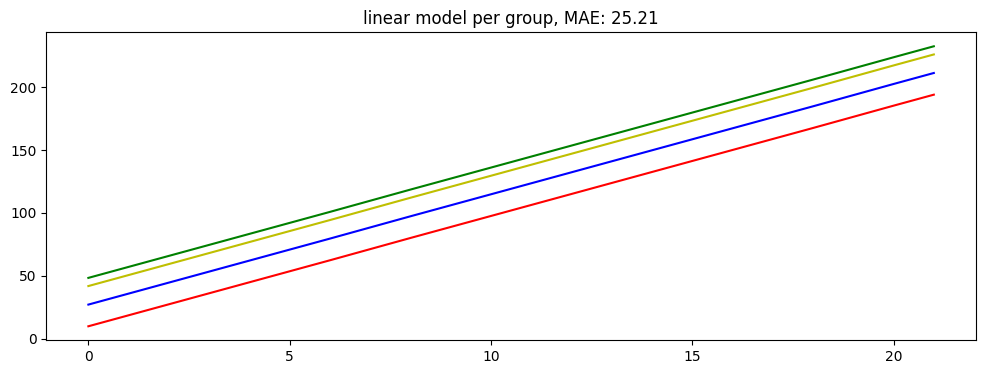

In [10]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto", sparse=False))
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("standardize", StandardScaler())
        ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

     diet  time  weight        pred
274     2    12     146  131.943231
416     3     8      80  109.633293
359     3    14     179  178.170519
447     3    21     272  258.130616
162     1    14     192  126.716141
338     2    20     157  200.816321
(578, 4)
    time  diet        pred
0      0     1   30.930980
1      2     1   44.614575
2      4     1   58.298169
3      6     1   71.981763
4      8     1   85.665358
5     10     1   99.348952
6     12     1  113.032547
7     14     1  126.716141
8     16     1  140.399735
9     18     1  154.083330
10    20     1  167.766924
11    21     1  174.608721
(12, 3)
     time  diet        pred
220     0     2   28.633596
221     2     2   45.851868
222     4     2   63.070141
223     6     2   80.288413
224     8     2   97.506686
225    10     2  114.724958
226    12     2  131.943231
227    14     2  149.161504
228    16     2  166.379776
229    18     2  183.598049
230    20     2  200.816321
231    21     2  209.425458
(12, 3)
     tim

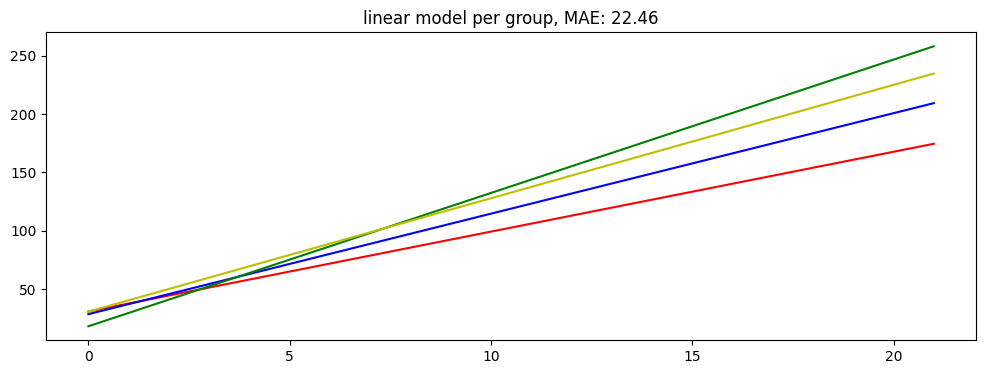

In [11]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

### Zero Inflated Regression

In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklego.meta import ZeroInflatedRegressor


df = (pd.DataFrame({'dt': pd.date_range("2018-01-01", "2021-01-01")})
      .assign(x=lambda q: np.random.normal(0,1, q.shape[0]))
      .assign(weekend = lambda d: (df['dt'].dt.weekday >= 5).astype(np.int16))#1~4 (0), 5,6 (1)
      .assign(y=lambda l: np.where(l['weekend'], 0, 1.5 + 0.87 * l['x'] + np.random.normal(0, 0.2, l.shape[0]))))
      #give zero to weekends and random numbers to non weekends

In [42]:
df.head(9)

,dt,x,weekend,y
0,2018-01-01,-0.196196,0,1.832504
1,2018-01-02,-0.581206,0,0.865044
2,2018-01-03,-0.139205,0,1.340875
3,2018-01-04,-0.621591,0,1.155840
4,2018-01-05,-1.146471,0,0.434208
5,2018-01-06,0.286905,1,0.000000
6,2018-01-07,-0.178455,1,0.000000
7,2018-01-08,-0.004869,0,1.640762
8,2018-01-09,0.833081,0,2.571876


In [32]:
X, y = df[['x', 'weekend']].values, df['y'].values

In [14]:
zir = ZeroInflatedRegressor(
    classifier=LogisticRegression(),
    regressor=Ridge() #linear regression iak form (loss function)
)

lr = Ridge(random_state=0)

print('ZIR r²:', cross_val_score(zir, X, y).mean())
print(' LR r²:', cross_val_score(lr, X, y).mean())

ZIR r²: 0.9714693535778125
 LR r²: 0.840606332429871


### Decay

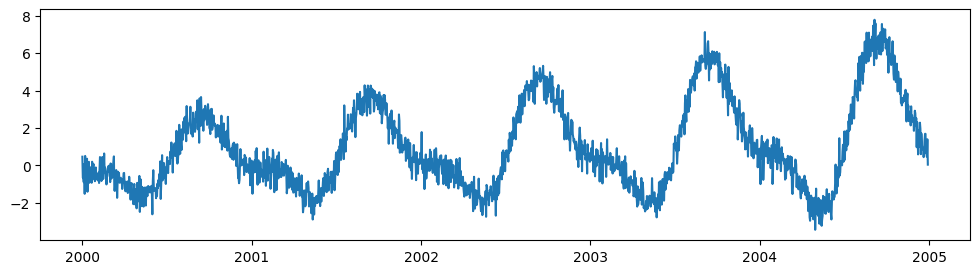

In [15]:
from sklearn.dummy import DummyRegressor
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries
import matplotlib.pylab as plt 

yt = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(yt))
df = (pd.DataFrame({"yt": yt,
                  "date": dates})
      .assign(m=lambda d: d.date.dt.month)
      .reset_index())

plt.figure(figsize=(12, 3))
plt.plot(dates, make_simpleseries(seed=1));

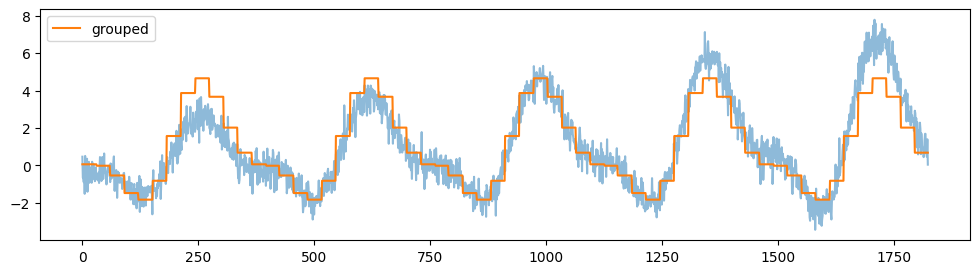

In [16]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
  .fit(df[['m']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.legend();

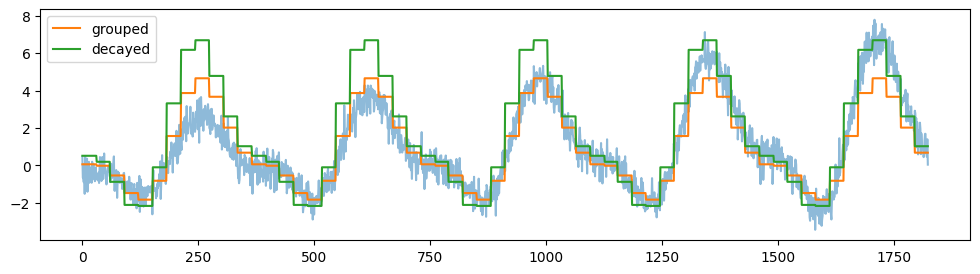

In [17]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
  .fit(df[['m']], df['yt']))

mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
        .fit(df[['index', 'm']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend();

In [18]:
tst = load_chicken(as_frame=True)
tst

,weight,time,chick,diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1
...,...,...,...,...
573,175,14,50,4
574,205,16,50,4
575,234,18,50,4
576,264,20,50,4
